# Per country projections of ICU need and total affected population percentage
> Modeling current and future ICU demand and percentage of affected population. 

- comments: true
- categories: [overview]
- author: artdgn
- image: images/covid-progress-projections.png
- permalink: /covid-progress-projections/
- toc: true
- hide: false

> Note: This dashboard contains the results of a predictive model. The author has tried to make it as accurate as possible. But the COVID-19 situation is changing quickly, and these models inevitably include some level of speculation. 

In [1]:
#hide
import pandas as pd
import overview_helpers

helper = overview_helpers.OverviewDataExtras
df = helper.filter_df(helper.table_with_projections())
df.columns

Index(['Cases.new', 'Cases.new.est', 'Cases.new.per100k',
       'Cases.new.per100k.est', 'Cases.total', 'Cases.total.est',
       'Cases.total.per100k', 'Cases.total.per100k.est', 'Continent',
       'Deaths.new', 'Deaths.new.per100k', 'Deaths.total',
       'Deaths.total.per100k', 'Fatality Rate', 'affected_ratio',
       'affected_ratio.est', 'affected_ratio.est.+14d',
       'affected_ratio.est.+30d', 'affected_ratio.est.+60d',
       'affected_ratio.est.+7d', 'affected_ratio.est.+90d', 'growth_rate',
       'icu_capacity_per100k', 'icu_spare_capacity_per100k', 'needICU.per100k',
       'needICU.per100k.+14d', 'needICU.per100k.+30d', 'needICU.per100k.+60d',
       'needICU.per100k.+7d', 'needICU.per100k.+90d', 'peak_icu_neek_per100k',
       'population', 'testing_bias'],
      dtype='object')

## Top 20 by estimated need for ICU beds
- ICU need is estimated as [6% of active cases](https://medium.com/@joschabach/flattening-the-curve-is-a-deadly-delusion-eea324fe9727).
- ICU capacities are from [Wikipedia](https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds) (OECD countries mostly) and [CCB capacities in Asia](https://www.researchgate.net/publication/338520008_Critical_Care_Bed_Capacity_in_Asian_Countries_and_Regions).
- ICU spare capacity is based on 70% normal occupancy rate ([66% in US](https://www.sccm.org/Blog/March-2020/United-States-Resource-Availability-for-COVID-19), [75% OECD](https://www.oecd-ilibrary.org/social-issues-migration-health/health-at-a-glance-2019_4dd50c09-en))
- Details of estimation and prediction calculations are in [Appendix](#appendix).
- Column definitions:
    - **Estimated ICU need per 100k population**: number of ICU beds estimated to be needed per 100k population by COVID-19 patents.
    - **Projected in 14 days**: projected ICU need per 100k population in 14 days.
    - **Projected in 30 days**: projected ICU need per 100k population in 30 days.
    - **ICU capacity per 100k**: number of ICU beds per 100k population.
    - **Estimated ICU Spare capacity per 100k**: estimated ICU capacity per 100k population based on assumed normal occupancy rate of 70% and number of ICU beds (only for countries with ICU beds data).
    - **Estimated daily case growth rate**: percentage daily change in total cases during last 5 days.
> Tip: The <b><font color="b21e3e">red (need for ICU)</font></b>  and the <b><font color="3ab1d8">blue (ICU spare capacity)</font></b>  bars are on the same 0-10 scale, for easy visual comparison of columns.

In [2]:
#hide_input
rename_cols = {'needICU.per100k': 'Estimated <br> ICU need <br> per 100k <br> population',
               'needICU.per100k.+14d': 'Projected <br> In 14 days', 
               'needICU.per100k.+30d': 'Projected <br> In 30 days',               
               'icu_capacity_per100k': 'ICU <br> capacity <br> per 100k',
               'icu_spare_capacity_per100k': 'Estimated ICU <br> Spare capacity <br> per 100k',               
               'growth_rate': 'Estimated <br> daily case <br> growth rate',
              }
icu_cols = list(rename_cols.values())[:3]
df_icu_bars = df.rename(rename_cols, axis=1)
df_icu_bars.sort_values(rename_cols['needICU.per100k'], ascending=False)\
[rename_cols.values()]\
.head(20).style\
    .bar(subset=icu_cols[0], color='#b21e3e', vmin=0, vmax=10)\
    .bar(subset=icu_cols[1], color='#f43d64', vmin=0, vmax=10)\
    .bar(subset=icu_cols[2], color='#ef8ba0', vmin=0, vmax=10)\
    .bar(subset=[rename_cols['icu_spare_capacity_per100k']], color='#3ab1d8', vmin=0, vmax=10)\
    .applymap(lambda _: 'color: blue', subset=[rename_cols['icu_spare_capacity_per100k']])\
    .bar(subset=[rename_cols['growth_rate']], color='#d65f5f', vmin=0, vmax=0.33)\
    .format('<b>{:.1%}</b>', subset=[rename_cols['growth_rate']])\
    .format('<b>{:.1f}</b>', subset=[rename_cols['icu_capacity_per100k']], na_rep="-")\
    .format('<b>{:.1f}</b>', subset=[rename_cols['icu_spare_capacity_per100k']], na_rep="-")\
    .format('<b>{:.2f}</b>', subset=icu_cols)\
    .set_precision(2)

,Estimated ICU need per 100k population,Projected In 14 days,Projected In 30 days,ICU capacity per 100k,Estimated ICU Spare capacity per 100k,Estimated daily case growth rate
Country/Region,,,,,,
US,0.95,4.87,30.23,34.7,10.4,14.8%
Spain,0.89,1.91,3.79,9.7,2.9,8.8%
Italy,0.67,0.95,1.42,12.5,3.8,4.5%
France,0.48,1.23,3.44,11.6,3.5,9.5%
United Kingdom,0.44,2.17,10.73,6.6,2.0,14.7%
Iran,0.19,0.36,0.76,4.6,1.4,7.3%
Belgium,0.13,0.35,1.00,15.9,4.8,10.7%
Turkey,0.12,1.03,10.94,47.1,14.1,19.1%
Netherlands,0.12,0.25,0.60,6.4,1.9,8.4%


## Affected population percentages in top 20 countries with most estimated new cases
- Sorted by number of estimated new cases during the last 5 days.
- Details of estimation and prediction calculations are in [Appendix](#appendix).
- Column definitions:
    - **Estimated <i>new</i> cases in last 5 days**: estimated new cases in last 5 days.
    - **Estimated <i>total</i> affected population percentage**: estimated percentage of total population already affected (infected, recovered, or dead).
    - **Projected in 14 days**: projected percentage of total affected population in 14 days.
    - **Projected in 30 days**: projected percentage of total affected population in 30 days.
    - **Reported fatality percentage**: reported total deaths divided by total cases.
    - **Estimated daily case growth rate**: percentage daily change in total cases during last 5 days.


In [3]:
#hide_input
rename_cols = {'Cases.new.est': 'Estimated <br> <i>new</i> cases <br> in last 5 days', 
               'affected_ratio.est': 'Estimated <br> <i>total</i> affected <br> population <br> percentage',
               'affected_ratio.est.+14d': 'Projected <br> In 14 days',
               'affected_ratio.est.+30d': 'Projected <br> In 30 days',
               'Fatality Rate': 'Reported <br> fatality <br> percentage',
               'growth_rate': 'Estimated <br> daily case <br> growth rate',
              }
progress_cols = list(rename_cols.values())[:4]
df_progress_bars = df.rename(rename_cols, axis=1)
df_progress_bars.sort_values(rename_cols['Cases.new.est'], ascending=False)\
[rename_cols.values()]\
.head(20).style\
    .bar(subset=progress_cols[0], color='#b57b17')\
    .bar(subset=progress_cols[1], color='#5dad64', vmin=0, vmax=1.0)\
    .bar(subset=progress_cols[2], color='#719974', vmin=0, vmax=1.0)\
    .bar(subset=progress_cols[3], color='#a1afa3', vmin=0, vmax=1.0)\
    .bar(subset=[rename_cols['Fatality Rate']], color='#420412', vmin=0, vmax=0.1)\
    .applymap(lambda _: 'color: red', subset=[rename_cols['Fatality Rate']])\
    .bar(subset=[rename_cols['growth_rate']], color='#d65f5f', vmin=0, vmax=0.33)\
    .format('<b>{:,.0f}</b>', subset=list(rename_cols.values())[0])\
    .format('<b>{:.1%}</b>', subset=list(rename_cols.values())[1:])

,Estimated new cases in last 5 days,Estimated total affected population percentage,Projected In 14 days,Projected In 30 days,Reported fatality percentage,Estimated daily case growth rate
Country/Region,,,,,,
US,"732,702",0.4%,2.5%,16.8%,2.4%,14.8%
Spain,"541,039",3.3%,9.2%,23.0%,9.2%,8.8%
United Kingdom,"341,266",1.0%,5.5%,31.0%,8.6%,14.7%
France,"306,831",1.3%,4.0%,12.7%,9.0%,9.5%
Italy,"283,981",2.4%,4.5%,8.3%,12.1%,4.5%
Iran,"117,464",0.5%,1.1%,2.6%,6.3%,7.3%
Turkey,"104,949",0.2%,1.9%,21.6%,2.0%,19.1%
Belgium,"84,900",1.8%,6.2%,20.5%,6.6%,10.7%
Netherlands,"69,042",1.2%,3.3%,9.2%,9.1%,8.4%


## Full table with more details
 - Contains reported data, estimations, projections, and numbers relative to population.
 - This is a busy table in order to present as many stats as possible for each country for people to be able to inspect their counties of interest in maximum amount detail (without running the code).
 - Sorted by projected need for ICU beds per 100k in 14 days. 
 - **New** in this table means **during last 5 days**.
 - Includes only countries with at least 10 deaths.
 > Tip: use Ctrl + F to find your country of interest in the table.

In [32]:
#hide_input
pretty_cols = {}

pretty_cols['cases'] = 'Cases <br> - Reported (+new) <br> - <i> Estimated (+new) </i>'
df[pretty_cols['cases']] =(df.apply(lambda r: f" \
                         {r['Cases.total']:,.0f} \
                         (+<b>{r['Cases.new']:,.0f}</b>) <br>\
                         <i>{r['Cases.total.est']:,.0f} \
                         (+<b>{r['Cases.new.est']:,.0f}</b></i> )\
                         ", axis=1))

pretty_cols['progress'] = ('Affected <br> percentage <br> \
                      - Reported <br> - <i>Estimated <br> Now / in <b>14</b> / 30 days</i>')
df[pretty_cols['progress']] =(df.apply(lambda r: f" \
                        {r['affected_ratio']:.2%} <br>\
                        <i>{r['affected_ratio.est']:.2%} \
                        <b>{r['affected_ratio.est.+14d']:.1%}</b> / \
                        {r['affected_ratio.est.+30d']:.1%}</i>", axis=1))

pretty_cols['icu'] = ('Estimated <br> Need for ICU <br> per 100k <br>\
                      Now <i> / in <b>14</b> / 30 days</i>')
df[pretty_cols['icu']] =(df.apply(lambda r: f"\
                        {r['needICU.per100k']:.2f} / \
                        <i><b>{r['needICU.per100k.+14d']:.1f}</b> / \
                        {r['needICU.per100k.+30d']:.1f}</i>", axis=1))

pretty_cols['deaths'] = 'Reported <br> Deaths <br> - Total (+new) <br> - <i>Per100k (+new)</i>'
df[pretty_cols['deaths']] =(df.apply(lambda r: f" \
                         {r['Deaths.total']:,.0f} \
                         (+<b>{r['Deaths.new']:,.0f}</b>) <br> \
                         <i>{r['Deaths.total.per100k']:,.1f} \
                         (+<b>{r['Deaths.new.per100k']:,.1f}</b></i>) \
                         ", axis=1))

df.sort_values('needICU.per100k.+14d', ascending=False)\
    [pretty_cols.values()]\
    .style.set_na_rep("-").set_properties(**{})

,Cases - Reported (+new) - Estimated (+new),Affected percentage - Reported - Estimated Now / in 14 / 30 days,Estimated Need for ICU per 100k Now / in 14 / 30 days,Reported Deaths - Total (+new) - Per100k (+new)
Country/Region,,,,
US,"243,453 (+121,975) 1,462,418 (+732,702 )",0.07% 0.44% 2.5% / 16.8%,0.95 / 4.9 / 30.2,"5,926 (+3,900) 1.8 (+1.2)"
United Kingdom,"34,173 (+16,861) 691,660 (+341,266 )",0.05% 1.02% 5.5% / 31.0%,0.44 / 2.2 / 10.7,"2,926 (+1,905) 4.3 (+2.8)"
Spain,"112,065 (+38,830) 1,561,463 (+541,039 )",0.24% 3.34% 9.2% / 23.0%,0.89 / 1.9 / 3.8,"10,348 (+4,366) 22.1 (+9.3)"
France,"59,929 (+21,824) 842,563 (+306,831 )",0.09% 1.29% 4.0% / 12.7%,0.48 / 1.2 / 3.4,"5,398 (+3,081) 8.3 (+4.7)"
Turkey,"18,135 (+10,733) 177,327 (+104,949 )",0.02% 0.21% 1.9% / 21.6%,0.12 / 1.0 / 10.9,356 (+248) 0.4 (+0.3)
Italy,"115,242 (+22,770) 1,437,265 (+283,981 )",0.19% 2.38% 4.5% / 8.3%,0.67 / 1.0 / 1.4,"13,915 (+3,892) 23.0 (+6.4)"
Iran,"50,468 (+15,060) 393,637 (+117,464 )",0.06% 0.47% 1.1% / 2.6%,0.19 / 0.4 / 0.8,"3,160 (+643) 3.8 (+0.8)"
Belgium,"15,348 (+6,214) 209,696 (+84,900 )",0.13% 1.81% 6.2% / 20.5%,0.13 / 0.4 / 1.0,"1,011 (+658) 8.7 (+5.7)"
Brazil,"8,044 (+4,140) 68,214 (+35,108 )",0.00% 0.03% 0.2% / 2.6%,0.04 / 0.3 / 3.4,324 (+213) 0.2 (+0.1)


<a id='appendix'></a>
## Appendix
- I'm not an epidemiologist. This is an attempt to understand what's happening, and what the future looks like if current trends remain unchanged.
- Everything is approximated and depends heavily on underlying assumptions.
- Total case estimation calculated from deaths by:
    - Assuming that unbiased fatality rate is 1.5% (from heavily tested countries / the cruise ship data) and that it takes 8 days on average for a case to go from being confirmed positive (after incubation + testing lag) to death. This is the same figure used by ["Estimating The Infected Population From Deaths"](https://covid19dashboards.com/covid-infected/) in this repo.
    - Testing bias: the actual lagged fatality rate is than divided by the 1.5% figure to estimate the testing bias in a country. The estimated testing bias then multiplies the reported case numbers to estimate the *true* case numbers (*=case numbers if testing coverage was as comprehensive as in the heavily tested countries*).
    - The testing bias calculation is a high source of uncertainty in all these estimations and projections. Better source of testing bias (or just *true case* numbers), should make everything more accurate.
- Projection is done using a simple [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) with (see [examples](#examples)) combined with the approach in [Total Outstanding Cases](https://covid19dashboards.com/outstanding_cases/#Appendix:-Methodology-of-Predicting-Recovered-Cases):
    - Growth rate calculated over the 5 past days. This is pessimistic - because it includes the testing rate growth rate as well, and is slow to react to both improvements in test coverage and "flattening" due to social isolation.
    - Recovery probability being 1/20 (for 20 days to recover) where the rate estimated from [Total Outstanding Cases](https://covid19dashboards.com/outstanding_cases/#Appendix:-Methodology-of-Predicting-Recovered-Cases) is too high (on down-slopes).
- ICU need is calculated as being [6% of active cases](https://medium.com/@joschabach/flattening-the-curve-is-a-deadly-delusion-eea324fe9727) where:
    - Active cases are taken from the SIR model.
    - This is both pessimistic - because real ICU rate may in reality be lower, due to testing biases, and especially in "younger" populations), and optimistic - because active cases which are on ICU take longer (so need the ICUs for longer).
    - ICU capacities are from [Wikipedia](https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds) (OECD countries mostly) and [CCB capacities in Asia](https://www.researchgate.net/publication/338520008_Critical_Care_Bed_Capacity_in_Asian_Countries_and_Regions).
    - ICU spare capacity is based on 70% normal occupancy rate ([66% in US](https://www.sccm.org/Blog/March-2020/United-States-Resource-Availability-for-COVID-19), [75% OECD](https://www.oecd-ilibrary.org/social-issues-migration-health/health-at-a-glance-2019_4dd50c09-en))

<a id='examples'></a>
### Examples of modeling plots 
- For the 5 countries with highest estimated number of new cases.
> Note: The purpose is to demonstrate the actual calculations used in the tables above and the dynamics of the model.

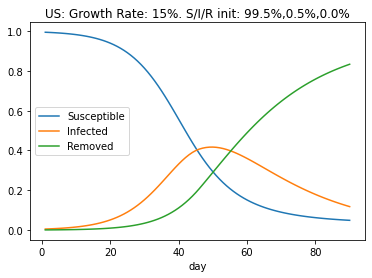

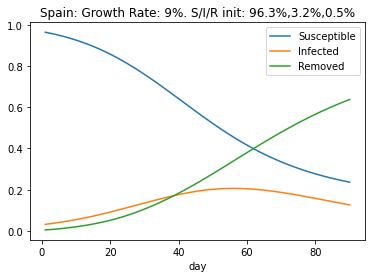

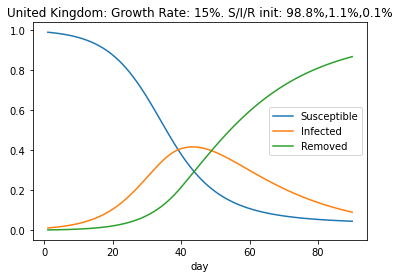

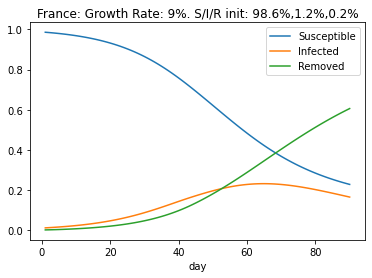

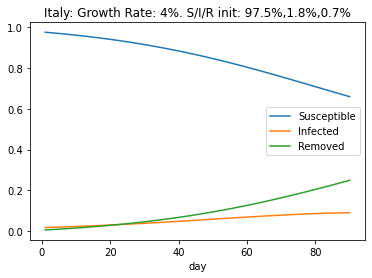

In [5]:
#hide_input
sir_plot_countries = df.sort_values('Cases.new.est', ascending=False).head(5).index
helper.table_with_projections(plot_countries=sir_plot_countries);